In [4]:
import numpy as np
from matplotlib import pyplot as plt, ticker as mticker
from tqdm import tqdm
from mdp_description import MDPDescription
from new_mdp_description import NewMDPDescription, BoundType
from scipy.special import rel_entr
import pickle
from scipy.stats import bootstrap
from matplotlib.transforms import Affine2D
from riverswim import RiverSwim
from scipy.stats import bootstrap
from scipy.stats import t
from matplotlib.ticker import StrMethodFormatter, NullFormatter,LogFormatterSciNotation
import matplotlib.style as style
from riverswim import RiverSwim
from forked_riverswim import ForkedRiverSwim
from simplified_new_mdp_description import SimplifiedNewMDPDescription
np.random.seed(2)
colors = ['magenta','black', 'darkorange', 'blue', 'red']

def TV(p,q):
    return np.sum(np.abs(p-q)) * 0.5

def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = t.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)

def compute_ce_median(values, c=0.95):
    ce = list(map(lambda k: bootstrap((values[:,k],), np.median, confidence_level=c).confidence_interval, range(values.shape[1])))
    res = np.array([(x.low, x.high) for x in ce])
    return np.median(values, axis=0), res[:, 0], res[:, 1]

def computeMK(mdp,k):
    P = mdp.P.reshape(mdp.dim_state * mdp.dim_action, -1)
    temp = (mdp.V_greedy[:, np.newaxis, np.newaxis] - mdp.avg_V_greedy[np.newaxis, ...]) ** (2*k)
    Mk = (P * temp.reshape(mdp.dim_state, mdp.dim_state * mdp.dim_action).T).sum(-1).reshape(mdp.dim_state, mdp.dim_action)
    return Mk

import matplotlib as mpl
TITLE_SIZE = 24
LEGEND_SIZE = 15
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 18
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": [
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r'\usepackage{amsmath}',
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
        r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
        r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
        r'\usepackage{helvet}',    # set the normal font here
        r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
        r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
    ]
})

discount_factor = 0.99

In [91]:
Nvalues = [5, 10, 25, 50, 100]
N_SIMS = 30

U_original_bound = np.zeros((N_SIMS, len(Nvalues)))
U_new_bound_t0 = np.zeros((N_SIMS, len(Nvalues)))
U_new_bound_t1 = np.zeros((N_SIMS, len(Nvalues)))
U_new_bound_simplified = np.zeros((N_SIMS, len(Nvalues)))
U_minimax = np.zeros((N_SIMS, len(Nvalues)))

U_new_bound_t0_original_omega = np.zeros((N_SIMS, len(Nvalues)))
U_new_bound_t1_original_omega = np.zeros((N_SIMS, len(Nvalues)))
U_new_bound_t0_simplified_omega = np.zeros((N_SIMS, len(Nvalues)))
U_new_bound_t1_simplified_omega = np.zeros((N_SIMS, len(Nvalues)))

policies_original_bound = []
policies_new_bound_t0 = []
policies_new_bound_t1 = []
policies_simplified_bound = []

TV_policy_new_bound_t0_vs_original_policy = np.zeros((N_SIMS, len(Nvalues)))
TV_policy_new_bound_t1_vs_original_policy = np.zeros((N_SIMS, len(Nvalues)))
TV_policy_new_bound_t0_vs_simplified_policy = np.zeros((N_SIMS, len(Nvalues)))
TV_policy_new_bound_t1_vs_simplified_policy = np.zeros((N_SIMS, len(Nvalues)))



for j in tqdm(range(N_SIMS)):
    _policies_original_bound = []
    _policies_new_bound_t0 = []
    _policies_new_bound_t1 = []
    _policies_simplified_bound = []
    for id_N, N in enumerate(Nvalues):
        theta = np.ones(N) + np.linspace(0, N/10 - 0.1, N).cumsum()
        P = np.random.dirichlet(theta, size=(N, 3))
        R = np.random.dirichlet(theta, size=(N, 3))
            
        mdp = MDPDescription(P, R, discount_factor)
        new_mdp = NewMDPDescription(P, R, discount_factor)
        simplified_mdp = SimplifiedNewMDPDescription(P, R, discount_factor, 1)
        
        
        # Classical upper bound
        U_generative_policy, U_generative_value = mdp.compute_allocation()
        U_original_bound[j,id_N] = U_generative_value
        _policies_original_bound.append(np.array(U_generative_policy))

        U_minimax[j,id_N] = N*3 / ((1-discount_factor)**3 * mdp.delta_sq_min)

        # U0
        p,v = new_mdp.compute_allocation(type=BoundType.BOUND_1)
        U_new_bound_t0[j,id_N] = v
        _policies_new_bound_t0.append(np.array(p))
        
        # U1
        p, v = new_mdp.compute_allocation(type=BoundType.BOUND_2)
        U_new_bound_t1[j,id_N] = v
        _policies_new_bound_t1.append(np.array(p))
        
        # Simplified
        p, v = simplified_mdp.compute_allocation(type=1)
        U_new_bound_simplified[j,id_N] = v
        _policies_simplified_bound.append(np.array(p))

        # Policies

        U_new_bound_t0_original_omega[j,id_N] = new_mdp.evaluate_allocation(U_generative_policy, type=BoundType.BOUND_1)
        TV_policy_new_bound_t0_vs_original_policy[j,id_N] = TV(_policies_new_bound_t0[id_N], U_generative_policy)

        U_new_bound_t1_original_omega[j,id_N] = new_mdp.evaluate_allocation(U_generative_policy, type=BoundType.BOUND_2)
        TV_policy_new_bound_t1_vs_original_policy[j,id_N] = TV(_policies_new_bound_t1[id_N], U_generative_policy)
        
        U_new_bound_t0_simplified_omega[j,id_N] = new_mdp.evaluate_allocation(_policies_simplified_bound[id_N], type=BoundType.BOUND_1)
        TV_policy_new_bound_t0_vs_simplified_policy[j,id_N] = TV(_policies_new_bound_t0[id_N], _policies_simplified_bound[id_N])
        
        U_new_bound_t1_simplified_omega[j,id_N] = new_mdp.evaluate_allocation(_policies_simplified_bound[id_N], type=BoundType.BOUND_2)
        TV_policy_new_bound_t1_vs_simplified_policy[j,id_N] = TV(_policies_new_bound_t1[id_N], _policies_simplified_bound[id_N])
    
    policies_original_bound.append(_policies_original_bound)
    policies_new_bound_t0.append(_policies_new_bound_t0)
    policies_new_bound_t1.append(_policies_new_bound_t1)
    policies_simplified_bound.append(_policies_simplified_bound)
with open('./data/new_data_generative_randommdp.pkl', 'wb') as f:
    data = {
        'Nvalues': Nvalues,
        'U_original_bound': U_original_bound,
        'U_new_bound_t0': U_new_bound_t0,
        'U_new_bound_t1': U_new_bound_t1,
        'U_new_bound_simplified': U_new_bound_simplified,
        'U_minimax': U_minimax,
        'U_new_bound_t0_original_omega': U_new_bound_t0_original_omega,
        'U_new_bound_t1_original_omega': U_new_bound_t1_original_omega,
        'U_new_bound_t0_simplified_omega': U_new_bound_t0_simplified_omega,
        'U_new_bound_t1_simplified_omega': U_new_bound_t1_simplified_omega,
        'policies_original_bound': policies_original_bound,
        'policies_new_bound_t0': policies_new_bound_t0,
        'policies_new_bound_t1': policies_new_bound_t1,
        'policies_simplified_bound': policies_simplified_bound,
        'TV_policy_new_bound_t0_vs_original_policy': TV_policy_new_bound_t0_vs_original_policy,
        'TV_policy_new_bound_t1_vs_original_policy': TV_policy_new_bound_t1_vs_original_policy,
        'TV_policy_new_bound_t0_vs_simplified_policy': TV_policy_new_bound_t0_vs_simplified_policy,
        'TV_policy_new_bound_t1_vs_simplified_policy': TV_policy_new_bound_t1_vs_simplified_policy
    }
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 30/30 [1:50:13<00:00, 220.43s/it]


In [24]:
N = 100
theta = np.ones(N) + np.linspace(0, N/10 - 0.1, N).cumsum()
theta

array([  1. ,   1.1,   1.3,   1.6,   2. ,   2.5,   3.1,   3.8,   4.6,
         5.5,   6.5,   7.6,   8.8,  10.1,  11.5,  13. ,  14.6,  16.3,
        18.1,  20. ,  22. ,  24.1,  26.3,  28.6,  31. ,  33.5,  36.1,
        38.8,  41.6,  44.5,  47.5,  50.6,  53.8,  57.1,  60.5,  64. ,
        67.6,  71.3,  75.1,  79. ,  83. ,  87.1,  91.3,  95.6, 100. ,
       104.5, 109.1, 113.8, 118.6, 123.5, 128.5, 133.6, 138.8, 144.1,
       149.5, 155. , 160.6, 166.3, 172.1, 178. , 184. , 190.1, 196.3,
       202.6, 209. , 215.5, 222.1, 228.8, 235.6, 242.5, 249.5, 256.6,
       263.8, 271.1, 278.5, 286. , 293.6, 301.3, 309.1, 317. , 325. ,
       333.1, 341.3, 349.6, 358. , 366.5, 375.1, 383.8, 392.6, 401.5,
       410.5, 419.6, 428.8, 438.1, 447.5, 457. , 466.6, 476.3, 486.1,
       496. ])

In [9]:
Nvalues = [5, 10, 25, 50, 100]

U_original_bound = np.zeros(len(Nvalues))
U_new_bound_t0 = np.zeros(len(Nvalues))
U_new_bound_t1 = np.zeros(len(Nvalues))
U_new_bound_simplified = np.zeros(len(Nvalues))
U_minimax = np.zeros(len(Nvalues))

U_new_bound_t0_original_omega = np.zeros(len(Nvalues))
U_new_bound_t1_original_omega = np.zeros(len(Nvalues))
U_new_bound_t0_simplified_omega = np.zeros(len(Nvalues))
U_new_bound_t1_simplified_omega = np.zeros(len(Nvalues))

policies_original_bound = []
policies_new_bound_t0 = []
policies_new_bound_t1 = []
policies_simplified_bound = []

TV_policy_new_bound_t0_vs_original_policy = np.zeros(len(Nvalues))
TV_policy_new_bound_t1_vs_original_policy = np.zeros(len(Nvalues))
TV_policy_new_bound_t0_vs_simplified_policy = np.zeros(len(Nvalues))
TV_policy_new_bound_t1_vs_simplified_policy = np.zeros(len(Nvalues))

mdp = {}
new_mdp = {}
simplified_mdp = {}

for id_N, N in enumerate(Nvalues):
    print(N)
    env = RiverSwim(num_states=N)
    mdp[id_N] = MDPDescription(env.transitions, env.rewards, discount_factor)
    new_mdp[id_N] = NewMDPDescription(env.transitions, env.rewards, discount_factor)
    simplified_mdp[id_N] = SimplifiedNewMDPDescription(env.transitions, env.rewards, discount_factor, 1)
    
    
    # Classical upper bound
    U_generative_policy, U_generative_value = mdp[id_N].compute_allocation()
    U_original_bound[id_N] = U_generative_value
    policies_original_bound.append(np.array(U_generative_policy))

    U_minimax[id_N] = env.ns*env.na / ((1-discount_factor)**3 * mdp[id_N].delta_sq_min)

    # U0
    p,v = new_mdp[id_N].compute_allocation(type=BoundType.BOUND_1)
    U_new_bound_t0[id_N] = v
    policies_new_bound_t0.append(np.array(p))
    
    # U1
    p, v = new_mdp[id_N].compute_allocation(type=BoundType.BOUND_2)
    U_new_bound_t1[id_N] = v
    policies_new_bound_t1.append(np.array(p))
    
    # Simplified
    p, v = simplified_mdp[id_N].compute_allocation(type=1)
    U_new_bound_simplified[id_N] = v
    policies_simplified_bound.append(np.array(p))

    # Policies

    U_new_bound_t0_original_omega[id_N] = new_mdp[id_N].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_1)
    TV_policy_new_bound_t0_vs_original_policy[id_N] = TV(policies_new_bound_t0[id_N], U_generative_policy)

    U_new_bound_t1_original_omega[id_N] = new_mdp[id_N].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_2)
    TV_policy_new_bound_t1_vs_original_policy[id_N] = TV(policies_new_bound_t1[id_N], U_generative_policy)
    
    U_new_bound_t0_simplified_omega[id_N] = new_mdp[id_N].evaluate_allocation(policies_simplified_bound[id_N], type=BoundType.BOUND_1)
    TV_policy_new_bound_t0_vs_simplified_policy[id_N] = TV(policies_new_bound_t0[id_N], policies_simplified_bound[id_N])
    
    U_new_bound_t1_simplified_omega[id_N] = new_mdp[id_N].evaluate_allocation(policies_simplified_bound[id_N], type=BoundType.BOUND_2)
    TV_policy_new_bound_t1_vs_simplified_policy[id_N] = TV(policies_new_bound_t1[id_N], policies_simplified_bound[id_N])
        
with open('./data/new_data_generative_riverswim.pkl', 'wb') as f:
    data = {
        'Nvalues': Nvalues,
        'U_original_bound': U_original_bound,
        'U_new_bound_t0': U_new_bound_t0,
        'U_new_bound_t1': U_new_bound_t1,
        'U_new_bound_simplified': U_new_bound_simplified,
        'U_minimax': U_minimax,
        'U_new_bound_t0_original_omega': U_new_bound_t0_original_omega,
        'U_new_bound_t1_original_omega': U_new_bound_t1_original_omega,
        'U_new_bound_t0_simplified_omega': U_new_bound_t0_simplified_omega,
        'U_new_bound_t1_simplified_omega': U_new_bound_t1_simplified_omega,
        'policies_original_bound': policies_original_bound,
        'policies_new_bound_t0': policies_new_bound_t0,
        'policies_new_bound_t1': policies_new_bound_t1,
        'policies_simplified_bound': policies_simplified_bound,
        'TV_policy_new_bound_t0_vs_original_policy': TV_policy_new_bound_t0_vs_original_policy,
        'TV_policy_new_bound_t1_vs_original_policy': TV_policy_new_bound_t1_vs_original_policy,
        'TV_policy_new_bound_t0_vs_simplified_policy': TV_policy_new_bound_t0_vs_simplified_policy,
        'TV_policy_new_bound_t1_vs_simplified_policy': TV_policy_new_bound_t1_vs_simplified_policy
    }
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

5
10
25
50
100


In [2]:
Nvalues = [3, 6, 13, 26, 51]

U_original_bound = np.zeros(len(Nvalues))
U_new_bound_t0 = np.zeros(len(Nvalues))
U_new_bound_t1 = np.zeros(len(Nvalues))
U_new_bound_simplified = np.zeros(len(Nvalues))
U_minimax = np.zeros(len(Nvalues))

U_new_bound_t0_original_omega = np.zeros(len(Nvalues))
U_new_bound_t1_original_omega = np.zeros(len(Nvalues))
U_new_bound_t0_simplified_omega = np.zeros(len(Nvalues))
U_new_bound_t1_simplified_omega = np.zeros(len(Nvalues))

policies_original_bound = []
policies_new_bound_t0 = []
policies_new_bound_t1 = []
policies_simplified_bound = []

TV_policy_new_bound_t0_vs_original_policy = np.zeros(len(Nvalues))
TV_policy_new_bound_t1_vs_original_policy = np.zeros(len(Nvalues))
TV_policy_new_bound_t0_vs_simplified_policy = np.zeros(len(Nvalues))
TV_policy_new_bound_t1_vs_simplified_policy = np.zeros(len(Nvalues))

mdp = {}
new_mdp = {}
simplified_mdp = {}

for id_N, N in enumerate(Nvalues):
    print(N)
    env = ForkedRiverSwim(river_length=N)
    mdp[id_N] = MDPDescription(env.transitions, env.rewards, discount_factor)
    new_mdp[id_N] = NewMDPDescription(env.transitions, env.rewards, discount_factor)
    simplified_mdp[id_N] = SimplifiedNewMDPDescription(env.transitions, env.rewards, discount_factor, 1)
    
    
    # Classical upper bound
    U_generative_policy, U_generative_value = mdp[id_N].compute_allocation()
    U_original_bound[id_N] = U_generative_value
    policies_original_bound.append(np.array(U_generative_policy))

    U_minimax[id_N] = env.ns*env.na / ((1-discount_factor)**3 * mdp[id_N].delta_sq_min)

    # U0
    p,v = new_mdp[id_N].compute_allocation(type=BoundType.BOUND_1)
    U_new_bound_t0[id_N] = v
    policies_new_bound_t0.append(np.array(p))
    
    # U1
    p, v = new_mdp[id_N].compute_allocation(type=BoundType.BOUND_2)
    U_new_bound_t1[id_N] = v
    policies_new_bound_t1.append(np.array(p))
    
    # Simplified
    p, v = simplified_mdp[id_N].compute_allocation(type=1)
    U_new_bound_simplified[id_N] = v
    policies_simplified_bound.append(np.array(p))

    # Policies

    U_new_bound_t0_original_omega[id_N] = new_mdp[id_N].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_1)
    TV_policy_new_bound_t0_vs_original_policy[id_N] = TV(policies_new_bound_t0[id_N], U_generative_policy)

    U_new_bound_t1_original_omega[id_N] = new_mdp[id_N].evaluate_allocation(U_generative_policy, type=BoundType.BOUND_2)
    TV_policy_new_bound_t1_vs_original_policy[id_N] = TV(policies_new_bound_t1[id_N], U_generative_policy)
    
    U_new_bound_t0_simplified_omega[id_N] = new_mdp[id_N].evaluate_allocation(policies_simplified_bound[id_N], type=BoundType.BOUND_1)
    TV_policy_new_bound_t0_vs_simplified_policy[id_N] = TV(policies_new_bound_t0[id_N], policies_simplified_bound[id_N])
    
    U_new_bound_t1_simplified_omega[id_N] = new_mdp[id_N].evaluate_allocation(policies_simplified_bound[id_N], type=BoundType.BOUND_2)
    TV_policy_new_bound_t1_vs_simplified_policy[id_N] = TV(policies_new_bound_t1[id_N], policies_simplified_bound[id_N])
        
with open('./data/new_data_generative_forked_riverswim.pkl', 'wb') as f:
    data = {
        'Nvalues': Nvalues,
        'U_original_bound': U_original_bound,
        'U_new_bound_t0': U_new_bound_t0,
        'U_new_bound_t1': U_new_bound_t1,
        'U_new_bound_simplified': U_new_bound_simplified,
        'U_minimax': U_minimax,
        'U_new_bound_t0_original_omega': U_new_bound_t0_original_omega,
        'U_new_bound_t1_original_omega': U_new_bound_t1_original_omega,
        'U_new_bound_t0_simplified_omega': U_new_bound_t0_simplified_omega,
        'U_new_bound_t1_simplified_omega': U_new_bound_t1_simplified_omega,
        'policies_original_bound': policies_original_bound,
        'policies_new_bound_t0': policies_new_bound_t0,
        'policies_new_bound_t1': policies_new_bound_t1,
        'policies_simplified_bound': policies_simplified_bound,
        'TV_policy_new_bound_t0_vs_original_policy': TV_policy_new_bound_t0_vs_original_policy,
        'TV_policy_new_bound_t1_vs_original_policy': TV_policy_new_bound_t1_vs_original_policy,
        'TV_policy_new_bound_t0_vs_simplified_policy': TV_policy_new_bound_t0_vs_simplified_policy,
        'TV_policy_new_bound_t1_vs_simplified_policy': TV_policy_new_bound_t1_vs_simplified_policy
    }
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

3
6
13
26
51


In [2]:
with open('./data/new_data_generative_randommdp.pkl', 'rb') as f:
    data_random_mdp = pickle.load(f)
    
with open('./data/new_data_generative_riverswim.pkl', 'rb') as f:
    data_riverswim = pickle.load(f)
    
with open('./data/new_data_generative_forked_riverswim.pkl', 'rb') as f:
    data_forked_riverswim = pickle.load(f)
    
# random_values_U = data['values_U']
# random_values_U0 = data['values_U0']
# random_values_U1 = data['values_U1']
# random_values_minimax = data['values_minimax']
# random_values_polU_U0 = data['values_polU_U0']
# random_values_polU_U1 = data['values_polU_U1']
# random_policies_U = data['policies_U']
# random_policies_U0 = data['policies_U0']
# random_policies_U1 = data['policies_U1']
# random_TV_polU0_vs_polU = data['TV_polU0_vs_polU']
# random_TV_polU1_vs_polU = data['TV_polU1_vs_polU']
# random_gap_sq_min = data['gap_sq_min']


# riverswim_values_U = data_riverswim['values_U']
# riverswim_values_U0 = data_riverswim['values_U0']
# riverswim_values_U1 = data_riverswim['values_U1']
# riverswim_values_minimax = data_riverswim['values_minimax']
# riverswim_values_polU_U0 = data_riverswim['values_polU_U0']
# riverswim_values_polU_U1 = data_riverswim['values_polU_U1']
# riverswim_policies_U = data_riverswim['policies_U']
# riverswim_policies_U0 = data_riverswim['policies_U0']
# riverswim_policies_U1 = data_riverswim['policies_U1']
# riverswim_TV_polU0_vs_polU = data_riverswim['TV_polU0_vs_polU']
# riverswim_TV_polU1_vs_polU = data_riverswim['TV_polU1_vs_polU']
# riverswim_gap_sq_min = data_riverswim['gap_sq_min']


# forked_riverswim_values_U = data_forked_riverswim['values_U']
# forked_riverswim_values_U0 = data_forked_riverswim['values_U0']
# forked_riverswim_values_U1 = data_forked_riverswim['values_U1']
# forked_riverswim_values_minimax = data_forked_riverswim['values_minimax']
# forked_riverswim_values_polU_U0 = data_forked_riverswim['values_polU_U0']
# forked_riverswim_values_polU_U1 = data_forked_riverswim['values_polU_U1']
# forked_riverswim_policies_U = data_forked_riverswim['policies_U']
# forked_riverswim_policies_U0 = data_forked_riverswim['policies_U0']
# forked_riverswim_policies_U1 = data_forked_riverswim['policies_U1']
# forked_riverswim_TV_polU0_vs_polU = data_forked_riverswim['TV_polU0_vs_polU']
# forked_riverswim_TV_polU1_vs_polU = data_forked_riverswim['TV_polU1_vs_polU']
# forked_riverswim_gap_sq_min = data_forked_riverswim['gap_sq_min']

(array([2.98065863e+12, 5.91641641e+13, 8.72764330e+18, 3.98702410e+23,
        1.00620099e+29]),
 array([1.31523032e+10, 3.02888281e+12, 1.97284877e+16, 1.61547553e+22,
        4.24335328e+27]),
 array([3.60361668e+12, 1.80290754e+14, 1.33208130e+19, 6.38700231e+24,
        4.22525868e+29]))

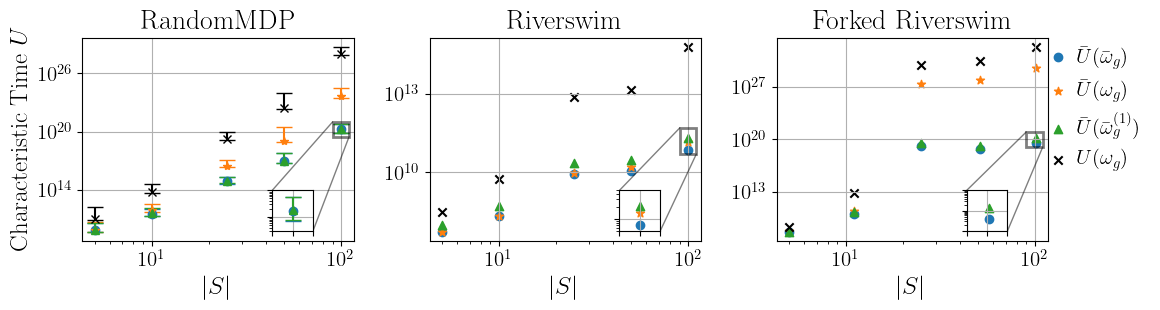

In [12]:
fig, ax = plt.subplots(1,3, figsize=(12,3.5))
fmts = ['o', '*', '^', 'x', '+']


# inset axes
axins = ax[0].inset_axes([0.7, 0.05, 0.15, 0.2], transform=ax[0].transAxes)

mu, ce_low, ce_high = compute_ce_median(data_random_mdp['U_new_bound_t0'])
ce = np.vstack([ce_low, ce_high])
ax[0].errorbar(data_random_mdp['Nvalues'], mu, ce, fmt=fmts[0], linewidth=1.5, capsize=6)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')
axins.errorbar(data_random_mdp['Nvalues'], mu, ce, fmt=fmts[0], linewidth=1.5, capsize=6)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')


mu, ce_low, ce_high = compute_ce_median(data_random_mdp['U_new_bound_t0_original_omega'])
ce = np.vstack([ce_low, ce_high])
ax[0].errorbar(data_random_mdp['Nvalues'], mu, ce, fmt=fmts[1], linewidth=1.5, capsize=6)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')
axins.errorbar(data_random_mdp['Nvalues'], mu, ce, fmt=fmts[1], linewidth=1.5, capsize=6)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')


mu, ce_low, ce_high = compute_ce_median(data_random_mdp['U_new_bound_t0_simplified_omega'])
ce = np.vstack([ce_low, ce_high])
ax[0].errorbar(data_random_mdp['Nvalues'], mu, ce, fmt=fmts[2], linewidth=1.5, capsize=6)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')
axins.errorbar(data_random_mdp['Nvalues'], mu, ce, fmt=fmts[2], linewidth=1.5, capsize=6)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')


mu, ce_low, ce_high = compute_ce_median(data_random_mdp['U_original_bound'])
ce = np.vstack([ce_low, ce_high])
ax[0].errorbar(data_random_mdp['Nvalues'], mu, ce, fmt=fmts[3], linewidth=1.5, color='k',capsize=6)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')
axins.errorbar(data_random_mdp['Nvalues'], mu, ce, fmt=fmts[3], linewidth=1.5, color='k',capsize=6)# label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')
# print(10**ce_low)
# print(10**ce_high)
# print(10**mu)

ax[0].set_xlabel('$|S|$')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].grid()



axins.set_xlim(90, 110)
axins.set_ylim(3e19, 1e21)
axins.set_yscale('log')
axins.grid()
axins.set_xticklabels([])
axins.set_yticklabels([])
ax[0].indicate_inset_zoom(axins, edgecolor="black",linewidth=2)



ax[1].scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0'], marker=fmts[0])
ax[1].scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0_original_omega'],  marker=fmts[1],label='value original omega')
ax[1].scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0_simplified_omega'], marker=fmts[2], label='value original omega')
ax[1].scatter(data_riverswim['Nvalues'], data_riverswim['U_original_bound'], marker=fmts[3], color='k',label='original')
ax[1].set_xlabel('$|S|$')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].grid()

# inset axes
axins = ax[1].inset_axes([0.7, 0.05, 0.15, 0.2], transform=ax[1].transAxes)
axins.scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0'], marker=fmts[0])
axins.scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0_original_omega'], marker=fmts[1])
axins.scatter(data_riverswim['Nvalues'], data_riverswim['U_new_bound_t0_simplified_omega'], marker=fmts[2])
axins.scatter(data_riverswim['Nvalues'], data_riverswim['U_original_bound'], marker=fmts[3], color='k')
axins.set_xlim(90, 110)
axins.set_ylim(5e10, 5e11)
axins.set_yscale('log')
axins.grid()
axins.set_xticklabels([])
axins.set_yticklabels([])
ax[1].indicate_inset_zoom(axins, edgecolor="black",linewidth=2)



xvalues_forked = np.array(data_forked_riverswim['Nvalues'])*2 -1

ax[2].scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0'], marker=fmts[0], label=r'$\bar U(\bar \omega_{g})$')
ax[2].scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0_original_omega'], marker=fmts[1], label=r'$\bar U(\omega_{g})$')
ax[2].scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0_simplified_omega'], marker=fmts[2], label=r'$\bar U(\bar \omega_{g}^{(1)})$')
ax[2].scatter(xvalues_forked, data_forked_riverswim['U_original_bound'], marker=fmts[3], color='k',label=r'$U(\omega_{g})$')
ax[2].set_xlabel('$|S|$')
ax[2].set_yscale('log')
ax[2].set_xscale('log')
ax[2].grid()



# inset axes
axins = ax[2].inset_axes([0.7, 0.05, 0.15, 0.2], transform=ax[2].transAxes)
axins.scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0'], marker=fmts[0])
axins.scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0_original_omega'], marker=fmts[1])
axins.scatter(xvalues_forked, data_forked_riverswim['U_new_bound_t0_simplified_omega'], marker=fmts[2])
axins.scatter(xvalues_forked, data_forked_riverswim['U_original_bound'], marker=fmts[3], color='k')
axins.set_xlim(90, 110)
axins.set_ylim(1e19, 1e21)
axins.set_yscale('log')
axins.grid()
axins.set_xticklabels([])
axins.set_yticklabels([])
ax[2].indicate_inset_zoom(axins, edgecolor="black",linewidth=2)


ax[0].set_ylabel('Characteristic Time $U$')
ax[0].set_title('RandomMDP')
ax[1].set_title('Riverswim')
ax[2].set_title('Forked Riverswim')

ax[2].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)
plt.tight_layout()
plt.savefig('./figures/bound_characteristic_time_analysis.pdf')


[2.10349585e+10 1.54182779e+13 3.69144804e+18 4.15752217e+21
 2.51663584e+27]
[1.67646731e+12 3.32811927e+14 7.10836007e+19 9.40669418e+23
 3.74035816e+28]
[1.00061611e+11 5.72989214e+13 1.88858663e+19 2.70934976e+22
 9.94323963e+27]


NameError: name 'random_values_U0' is not defined

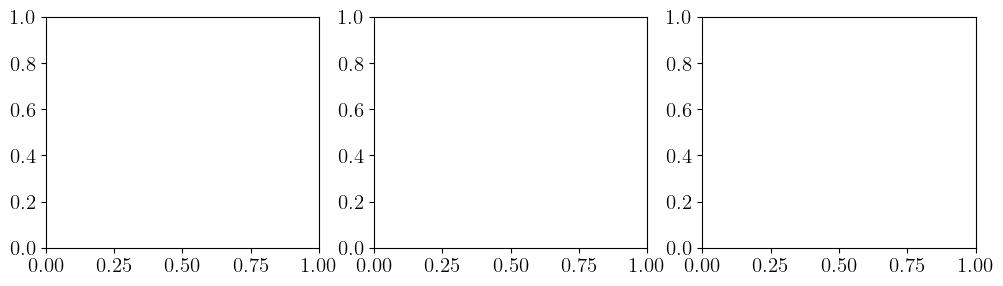

In [100]:


nk = 10
k_values = np.arange(1, nk+1)
fig,ax = plt.subplots(1,3, figsize=(12,3))

trans1 = Affine2D().translate(-0.15, 0.0) + ax[0].transData
trans2 = Affine2D().translate(+0.15, 0.0) + ax[0].transData


mu, ce_low, ce_high = compute_ce_median(random_values_U0[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[0].errorbar(k_values, mu, ce, fmt='o', linewidth=1.5, capsize=6, transform=trans1,  label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')


mu, ce_low, ce_high = compute_ce_median(random_values_polU_U0[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[0].errorbar(k_values, mu, ce, fmt='^', linewidth=1.5, capsize=6, transform=trans2,  label=r'$\bar U^{(\bar k)}(\omega_{gen,0})$')

mu, ce_low, ce_high = compute_ce_median(random_values_U[:, np.newaxis])
ce = np.vstack([ce_low, ce_high])
ax[0].errorbar(k_values, mu*np.ones(nk), ce*np.ones(nk), fmt='x', linewidth=1.5, capsize=6, color='k', alpha=0.8,label=r'$U(\omega_{gen,0})$')

ax[0].set_xticks(k_values)
ax[0].set_yscale('log')
ax[0].grid()

### Plot (0,1)

ax[1].scatter(k_values, riverswim_values_U*np.ones(nk),marker='x',alpha=0.8, color='k', label=r'$U(\omega_{g,0})$')
ax[1].scatter(k_values, riverswim_values_U0, marker='o',   label=r'$\bar U^{(\bar k)}(\bar\omega_{g,0}^{(\bar k)})$')
ax[1].scatter(k_values, riverswim_values_polU_U0, marker='^',  label=r'$\bar U^{(\bar k)}(\omega_{g,0})$')
ax[1].set_xticks(k_values)
ax[1].grid()
ax[1].set_yscale('log')
#ax[0,1].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)

### Plot (0,2)

ax[2].scatter(k_values, forked_riverswim_values_U*np.ones(nk),marker='x',alpha=0.8, color='k', label=r'$U(\omega_{g,0})$')
ax[2].scatter(k_values, forked_riverswim_values_U0, marker='o',   label=r'$\bar U^{(\bar k)}(\bar\omega_{g,0}^{(\bar k)})$')
ax[2].scatter(k_values, forked_riverswim_values_polU_U0, marker='^',  label=r'$\bar U^{(\bar k)}(\omega_{g,0})$')
ax[2].set_xticks(k_values)
ax[2].grid()
ax[2].set_yscale('log')
ax[2].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)




ax2 = ax[2].twinx() 
ax2.set_yticks([])
ax[0].set_xlabel(r'$\bar k$')
ax[1].set_xlabel(r'$\bar k$')
ax[2].set_xlabel(r'$\bar k$')
ax[0].set_ylabel('Characteristic Time $U$')
ax[0].set_title('RandomMDP')

ax[1].set_title('Riverswim(20)')
ax[2].set_title('Forked Riverswim(10)')
plt.tight_layout()
plt.savefig('./figures/bound_characteristic_time_analysis.pdf')



In [ ]:


nk = 10
k_values = np.arange(1, nk+1)
fig,ax = plt.subplots(2,3, figsize=(12,6))

trans1 = Affine2D().translate(-0.15, 0.0) + ax[0,0].transData
trans2 = Affine2D().translate(+0.15, 0.0) + ax[0,0].transData


mu, ce_low, ce_high = compute_ce_median(random_values_U0[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu, ce, fmt='o', linewidth=1.5, capsize=6, transform=trans1,  label=r'$\bar U^{(\bar k)}(\bar\omega_{gen,0}^{(\bar k)})$')


mu, ce_low, ce_high = compute_ce_median(random_values_polU_U0[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu, ce, fmt='^', linewidth=1.5, capsize=6, transform=trans2,  label=r'$\bar U^{(\bar k)}(\omega_{gen,0})$')

mu, ce_low, ce_high = compute_ce_median(random_values_U[:, np.newaxis])
ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu*np.ones(nk), ce*np.ones(nk), fmt='x', linewidth=1.5, capsize=6, color='k', alpha=0.8,label=r'$U(\omega_{gen,0})$')

ax[0,0].set_xticks(k_values)
ax[0,0].set_yscale('log')
ax[0,0].grid()

### Plot (0,1)

ax[0,1].scatter(k_values, riverswim_values_U*np.ones(nk),marker='x',alpha=0.8, color='k', label=r'$U(\omega_{g,0})$')
ax[0,1].scatter(k_values, riverswim_values_U0, marker='o',   label=r'$\bar U^{(\bar k)}(\bar\omega_{g,0}^{(\bar k)})$')
ax[0,1].scatter(k_values, riverswim_values_polU_U0, marker='^',  label=r'$\bar U^{(\bar k)}(\omega_{g,0})$')
ax[0,1].set_xticks(k_values)
ax[0,1].grid()
ax[0,1].set_yscale('log')
#ax[0,1].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)

### Plot (0,2)

ax[0,2].scatter(k_values, forked_riverswim_values_U*np.ones(nk),marker='x',alpha=0.8, color='k', label=r'$U(\omega_{g,0})$')
ax[0,2].scatter(k_values, forked_riverswim_values_U0, marker='o',   label=r'$\bar U^{(\bar k)}(\bar\omega_{g,0}^{(\bar k)})$')
ax[0,2].scatter(k_values, forked_riverswim_values_polU_U0, marker='^',  label=r'$\bar U^{(\bar k)}(\omega_{g,0})$')
ax[0,2].set_xticks(k_values)
ax[0,2].grid()
ax[0,2].set_yscale('log')
ax[0,2].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)




### Plot (1,0)
mu, ce = CE((random_TV_polU0_vs_polU[:, :nk]))
ax[1,0].errorbar(k_values, mu, ce, fmt='o', linewidth=2, capsize=6, label=r'${\rm TV}(\omega_{g,0}, \bar \omega_{g,0}^{(\bar k)})$')
ax[1,0].set_xticks(k_values)
ax[1,0].grid()
ax[1,0].set_xlabel(r'$\bar k$')
ax[1,0].set_yscale('log')
ax[1,0].yaxis.set_minor_formatter(NullFormatter())

### Plot (1,1)
ax[1,1].scatter(k_values, riverswim_TV_polU0_vs_polU, marker='o', label=r'${\rm TV}(\omega_{g,0}, \bar \omega_{g,0}^{(\bar k)})$')
ax[1,1].set_xticks(k_values)
ax[1,1].set_xlabel(r'$\bar k$')
ax[1,1].grid()
ax[1,1].set_yscale('log')

### Plot (1,1)
ax[1,2].scatter(k_values, forked_riverswim_TV_polU0_vs_polU, marker='o', label=r'${\rm TV}(\omega_{g,0}, \bar \omega_{g,0}^{(\bar k)})$')
ax[1,2].set_xticks(k_values)
ax[1,2].set_xlabel(r'$\bar k$')
ax[1,2].grid()
ax[1,2].set_yscale('log')
ax[1,2].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1.66, 1), borderaxespad=0)
ax2 = ax[0,1].twinx() 
ax2.set_yticks([])
ax[0,0].set_ylabel('Characteristic Time $U$')
ax[0,0].set_title('RandomMDP')

ax2 = ax[1,1].twinx() 
ax2.set_yticks([])

ax2 = ax[1,2].twinx() 
ax2.set_yticks([])
ax[1,0].set_ylabel(r'Total Variation')
ax[0,1].set_title('Riverswim(20)')
ax[0,2].set_title('ForekdRiverswim(10)')
ax[1,1].yaxis.set_minor_formatter(NullFormatter())
ax[1,2].yaxis.set_minor_formatter(NullFormatter())
ax[1,1].set_ylim((0.006, .55))
ax[1,2].set_ylim((0.1, 1))
plt.tight_layout()
# plt.savefig('./figures/bound_characteristic_time_analysis.pdf')
plt.plot()


In [ ]:

nk = 10
k_values = np.arange(1, nk+1)
fig,ax = plt.subplots(4,3, figsize=(12,12))

trans1 = Affine2D().translate(-0.15, 0.0) + ax[0,0].transData
trans2 = Affine2D().translate(+0.15, 0.0) + ax[0,0].transData

trans3 = Affine2D().translate(-0.15, 0.0) + ax[1,0].transData
trans4 = Affine2D().translate(+0.15, 0.0) + ax[1,0].transData


mu, ce_low, ce_high = compute_ce_median(random_values_U0[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu, ce, fmt='o', linewidth=1.5, capsize=6, transform=trans1,  label=r'$\bar U^{(\bar k)}(\bar\omega_{g,0}^{(\bar k)})$')

mu, ce_low, ce_high = compute_ce_median(random_values_polU_U0[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu, ce, fmt='^', linewidth=1.5, capsize=6, transform=trans2,  label=r'$\bar U^{(\bar k)}(\omega_{g,0})$')

mu, ce_low, ce_high = compute_ce_median(random_values_U[:, np.newaxis])
ce = np.vstack([ce_low, ce_high])
ax[0,0].errorbar(k_values, mu*np.ones(nk), ce*np.ones(nk), fmt='x', linewidth=1.5, capsize=6, color='k', alpha=0.8,label=r'$U(\omega_{g,0})$')

ax[0,0].set_xticks(k_values)
ax[0,0].grid()
ax[0,0].set_yscale('log')


mu, ce_low, ce_high = compute_ce_median(random_values_U1[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[1,0].errorbar(k_values, mu, ce, fmt='o', linewidth=1.5, capsize=6, transform=trans3,  label=r'$\hat U^{(\bar k)}(\bar\omega_{g,0}^{(\bar k)})$')


mu, ce_low, ce_high = compute_ce_median(random_values_polU_U1[:, :nk])
ce = np.vstack([ce_low, ce_high])
ax[1,0].errorbar(k_values, mu, ce, fmt='^', linewidth=1.5, capsize=6, transform=trans4,  label=r'$\hat U^{(\bar k)}(\omega_{g,0})$')

mu, ce_low, ce_high = compute_ce_median(random_values_U[:, np.newaxis])
ce = np.vstack([ce_low, ce_high])
ax[1,0].errorbar(k_values, mu*np.ones(nk), ce*np.ones(nk), fmt='x', linewidth=1.5, capsize=6, color='k', alpha=0.8,label=r'$U(\omega_{g,0})$')

ax[1,0].set_xticks(k_values)
ax[1,0].grid()
ax[1,0].set_yscale('log')


# (0,1)
ax[0,1].scatter(k_values, riverswim_values_U*np.ones(nk),marker='x',alpha=0.8, color='k', label=r'$U(\omega_{g,0})$')
ax[0,1].scatter(k_values, riverswim_values_U0, marker='o',   label=r'$\bar U^{(\bar k)}(\bar\omega_{g,0}^{(\bar k)})$')
ax[0,1].scatter(k_values, riverswim_values_polU_U0, marker='^',  label=r'$\bar U^{(\bar k)}(\omega_{g,0})$')
ax[0,1].set_xticks(k_values)
ax[0,1].grid()
ax[0,1].set_yscale('log')
# ax[0,1].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)



# (1,1)
ax[1,1].scatter(k_values, riverswim_values_U*np.ones(nk),marker='x',alpha=0.8, color='k', label=r'$U(\omega_{g,0})$')
ax[1,1].scatter(k_values, riverswim_values_U1, marker='o',   label=r'$\hat U^{(\bar k)}(\hat \omega_{g,0}^{(\bar k)})$')
ax[1,1].scatter(k_values, riverswim_values_polU_U1, marker='^',  label=r'$\hat U^{(\bar k)}(\omega_{g,0})$')
ax[1,1].set_xticks(k_values)
ax[1,1].grid()
ax[1,1].set_yscale('log')
# ax[1,1].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)

# (0,2)
ax[0,2].scatter(k_values, forked_riverswim_values_U*np.ones(nk),marker='x',alpha=0.8, color='k', label=r'$U(\omega_{g,0})$')
ax[0,2].scatter(k_values, forked_riverswim_values_U0, marker='o',   label=r'$\bar U^{(\bar k)}(\bar\omega_{g,0}^{(\bar k)})$')
ax[0,2].scatter(k_values, forked_riverswim_values_polU_U0, marker='^',  label=r'$\bar U^{(\bar k)}(\omega_{g,0})$')
ax[0,2].set_xticks(k_values)
ax[0,2].grid()
ax[0,2].set_yscale('log')
ax[0,2].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)



# (1,2)
ax[1,2].scatter(k_values, forked_riverswim_values_U*np.ones(nk),marker='x',alpha=0.8, color='k', label=r'$U(\omega_{g,0})$')
ax[1,2].scatter(k_values, forked_riverswim_values_U1, marker='o',   label=r'$\hat U^{(\bar k)}(\hat \omega_{g,0}^{(\bar k)})$')
ax[1,2].scatter(k_values, forked_riverswim_values_polU_U1, marker='^',  label=r'$\hat U^{(\bar k)}(\omega_{g,0})$')
ax[1,2].set_xticks(k_values)
ax[1,2].grid()
ax[1,2].set_yscale('log')
ax[1,2].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1, 1), borderaxespad=0)


# (2,1)

ax[2,1].scatter(k_values, riverswim_TV_polU0_vs_polU, marker='o', label=r'${\rm TV}(\omega_{g,0}, \bar \omega_{g,0}^{(\bar k)})$')

ax[2,1].set_xticks(k_values)
#ax[1,0].set_ylabel(r'${\rm TV}(\omega_{gen,0}, \bar \omega_{gen,0}^{(\bar k)})$')
ax[2,1].grid()
#ax[3].legend(  handlelength=1, ncols=1, framealpha=0.6)
ax[2,1].set_yscale('log')

# (2,2)

ax[2,2].scatter(k_values, forked_riverswim_TV_polU0_vs_polU, marker='o', label=r'${\rm TV}(\omega_{g,0}, \bar \omega_{g,0}^{(\bar k)})$')
ax[2,2].set_xticks(k_values)
ax[2,2].grid()
ax[2,2].set_yscale('log')


# (3,1)

ax[3,1].scatter(k_values, riverswim_TV_polU1_vs_polU, marker='o', label=r'${\rm TV}(\omega_{g,0}, \hat \omega_{g,0}^{(\bar k)})$')
ax[3,1].set_xticks(k_values)
ax[3,1].set_xlabel(r'$\bar k$')
ax[3,1].grid()
ax[3,1].set_yscale('log')

# (3,2)
ax[3,2].scatter(k_values, forked_riverswim_TV_polU1_vs_polU, marker='o', label=r'${\rm TV}(\omega_{g,0}, \hat \omega_{g,0}^{(\bar k)})$')
ax[3,2].set_xticks(k_values)
ax[3,2].set_xlabel(r'$\bar k$')
ax[3,2].grid()
ax[3,2].set_yscale('log')





mu, ce = CE((random_TV_polU0_vs_polU[:, :nk]))

ax[2,0].errorbar(k_values, mu, ce, fmt='o', linewidth=2, capsize=6, label=r'${\rm TV}(\omega_{g,0}, \bar \omega_{g,0}^{(\bar k)})$')
ax[2,0].set_xticks(k_values)
ax[2,0].grid()
ax[2,0].set_yscale('log')

mu, ce = CE((random_TV_polU1_vs_polU[:, :nk]))

ax[3,0].errorbar(k_values, mu, ce, fmt='o', linewidth=2, capsize=6, label=r'${\rm TV}(\omega_{g,0}, \hat \omega_{g,0}^{(\bar k)})$')
ax[3,0].set_xticks(k_values)
ax[3,0].grid()
ax[3,0].set_xlabel(r'$\bar k$')
ax[3,0].set_yscale('log')






from matplotlib.ticker import StrMethodFormatter, NullFormatter,LogFormatterSciNotation

ax[2,0].yaxis.set_minor_formatter(NullFormatter())
ax[3,0].yaxis.set_minor_formatter(NullFormatter())
ax[3,1].yaxis.set_minor_formatter(NullFormatter())
ax[2,2].yaxis.set_minor_formatter(NullFormatter())
ax[3,2].yaxis.set_minor_formatter(NullFormatter())
ax[3,1].set_ylim((1e-3, 1e-2))
ax[3,0].set_ylim((1e-3, 1e-2))
ax[2,2].set_ylim((1e-1, 1e-0))
ax[3,2].set_ylim((1e-3, 1e-2))
ax[2,2].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1.575, 1), borderaxespad=0)
ax[3,2].legend(ncols=1, handlelength=0.2,framealpha=0., bbox_to_anchor=(1.575, 1), borderaxespad=0)
ax2 = ax[0,1].twinx() 
ax2.set_yticks([])
ax[0,0].set_ylabel('Characteristic Time $U$')
ax[1,0].set_ylabel('Characteristic Time $U$')
ax[0,0].set_title('RandomMDP')

ax2 = ax[1,1].twinx() 
ax2.set_yticks([])
ax[2,0].set_ylabel(r'Total Variation')
ax[3,0].set_ylabel(r'Total Variation')
ax[0,1].set_title('Riverswim(20)')
ax[0,2].set_title('Forked Riverswim(10)')

ax2 = ax[2,1].twinx() 
ax2.set_yticks([])
ax2 = ax[3,1].twinx() 
ax2.set_yticks([])

ax2 = ax[2,2].twinx() 
ax2.set_yticks([])
ax2 = ax[3,2].twinx() 
ax2.set_yticks([])
ax2 = ax[0,0].twinx() 
ax2.set_yticks([])
ax2 = ax[1,0].twinx() 
ax2.set_yticks([])
ax2 = ax[2,0].twinx() 
ax2.set_yticks([])
ax2 = ax[3,0].twinx() 
ax2.set_yticks([])
plt.tight_layout()
plt.savefig('./figures/bound_characteristic_time_analysis_full.pdf')
plt.plot()

In [ ]:
### Compute statistics
N=300

delta_min = np.zeros(N)
var_v = np.zeros((N, 5, 4))
span_v = np.zeros((N, 5, 4))
delta_sa = np.zeros((N, 5, 4))
Mkvalues = np.zeros((N, 19))
for i in tqdm(range(N)):
    P = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(ns, na)) #
    R = np.random.dirichlet([1, 1.1, 1.3, 1.6, 2], size=(ns, na))
    mdp = MDPDescription(P, R, discount_factor)
    delta_min[i] = mdp.delta_sq_min ** 0.5
    var_v[i] = mdp.var_V_greedy
    span_v[i] = mdp.span_V_greedy
    delta_sa[i] = mdp.delta_sq ** 0.5
    
    Mkvalues[i] = [computeMK(mdp,x).max()** (2 ** (-x)) for x in range(1,20)]

In [ ]:
print('RandomMDP')
print(f'Delta_min: {CE(delta_min)}')
print(f'delta max: {CE(delta_sa.reshape(N,-1).max(-1))}')
print(f'span max: {CE(span_v.reshape(N,-1).max(-1))}')
print(f'span min: {CE(span_v.reshape(N,-1).min(-1))}')
print(f'Var max: {CE(var_v.reshape(N,-1).max(-1))}')
print(f'Var min: {CE(var_v.reshape(N,-1).min(-1))}')

barkmax = CE(Mkvalues.argmax(1) + 1)[0]
barkmin = CE(Mkvalues.argmin(1) + 1)[0]
print(f'Max Mk: {CE(Mkvalues.max(1) ** (2 ** barkmax))} - kbar: {CE(Mkvalues.argmax(1) + 1)}')
print(f'Max Mk: {CE(Mkvalues.min(1) ** (2 ** barkmin))} - kbar: {CE(Mkvalues.argmin(1) + 1)}')

In [ ]:
print('RiverSwim')
env = RiverSwim(num_states=20)
mdp = MDPDescription(env.transitions, env.rewards, discount_factor)

print(f'Delta_min: {mdp.delta_sq_min ** 0.5}')
print(f'delta max: {(mdp.delta_sq ** 0.5).max()}')
print(f'span max: {mdp.span_V_greedy.max()}')
print(f'span min: {mdp.span_V_greedy.min()}')
print(f'Var max: {mdp.var_V_greedy.max()}')
print(f'Var min: {mdp.var_V_greedy.min()}')
valK = [computeMK(mdp,x).max()** (2 ** (-x)) for x in range(1,20)]
print(f'Max Mk: {np.max(valK)} - kbar: {np.argmax(valK) + 1}')


In [ ]:
print('Forked RiverSwim')


env = ForkedRiverSwim(river_length=10)
mdp = MDPDescription(env.transitions, env.rewards, discount_factor)

print(f'Delta_min: {mdp.delta_sq_min ** 0.5}')
print(f'delta max: {(mdp.delta_sq ** 0.5).max()}')
print(f'span max: {mdp.span_V_greedy.max()}')
print(f'span min: {mdp.span_V_greedy.min()}')
print(f'Var max: {mdp.var_V_greedy.max()}')
print(f'Var min: {mdp.var_V_greedy.min()}')
valK = [computeMK(mdp,x).max()** (2 ** (-x)) for x in range(1,20)]
print(f'Max Mk: {np.max(valK)} - kbar: {np.argmax(valK)}')


In [ ]:
from riverswim import RiverSwim
from forked_riverswim import ForkedRiverSwim
discount_factor = 0.99

kvalues = range(1, 20)
num_states = [5, 10, 25, 50, 100]

values_riverswim = {N: [] for N in num_states}
values_forked_riverswim = {N: [] for N in num_states}
values_random_mdp = {N: [] for N in num_states}

    
def computeMK(mdp,k):
    P = mdp.P.reshape(mdp.dim_state * mdp.dim_action, -1)
    temp = (mdp.V_greedy[:, np.newaxis, np.newaxis] - mdp.avg_V_greedy[np.newaxis, ...]) ** (2*k)
    Mk = (P * temp.reshape(mdp.dim_state, mdp.dim_state * mdp.dim_action).T).sum(-1).reshape(mdp.dim_state, mdp.dim_action)
    return Mk

for N in num_states:
    env_rv = RiverSwim(num_states=N)
    env_frv = ForkedRiverSwim(river_length=N)

    mdp_rv = MDPDescription(env_rv.transitions, env_rv.rewards, discount_factor)
    mdp_frv = MDPDescription(env_frv.transitions, env_frv.rewards, discount_factor)
    for k in kvalues:
        mk_rv = computeMK(mdp_rv,k)
        mk_frv = computeMK(mdp_frv,k)
        values_riverswim[N].append(mk_rv.max() ** (2 ** (-k)))
        values_forked_riverswim[N].append(mk_frv.max() ** (2 ** (-k)))
        
    theta = np.ones(N) + np.linspace(0, N/10 - 0.1, N).cumsum()
    _rand_values = np.zeros((30,len(kvalues)))
    for j in range(_rand_values.shape[0]):
        P = np.random.dirichlet(theta, size=(N, N-1))
        R = np.random.dirichlet(theta, size=(N, N-1))
        mdp_random = MDPDescription(P, R, discount_factor)
        for idk, k in enumerate(kvalues):
            mk_random = computeMK(mdp_random, k)
            _rand_values[j,idk] = (mk_random.max()  ** (2 ** (-k)))
    values_random_mdp[N] = _rand_values
        
    

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

fmts = ['o', 'x', '^', '*', '+']
for axid, N in enumerate(num_states):
    mu, ce = CE(values_random_mdp[N])
    ce = np.vstack([ce, ce])
    
    ax[0].errorbar(kvalues, mu, ce, fmt=fmts[axid], linewidth=1.5, capsize=6,  label=f'$|S|={N}$')


    ax[1].scatter(kvalues, values_riverswim[N],marker=fmts[axid], label=f'$|S|={N}$')
    ax[2].scatter(kvalues, values_forked_riverswim[N],marker=fmts[axid], label=f'$|S|={N}$')

for i in range(3):
    ax[i].set_xlabel('$k$')
    #ax[i].set_yscale('log')
    ax[i].grid()
ax[2].legend(bbox_to_anchor=(1.45, 1), borderaxespad=0., frameon=False,borderpad=0.,labelspacing=0.5, handletextpad=0.)
ax[0].set_title('Random MDP')
ax[1].set_title('Riverswim')
ax[2].set_title('Forked Riverswim')
ax[0].set_ylabel(r'$\max_{s,a}M_{P_\phi(s,a)}^{(k)}[V_\phi^\star]^{2^{-k}}$')
plt.tight_layout()
plt.savefig('figures/evaluation_k.pdf')

In [2]:
env_frv = ForkedRiverSwim(5)

NewMDPDescriptionNew()
mdp_frv = MDPDescription(env_frv.transitions, env_frv.rewards, discount_factor)

values = np.zeros((len(kvalues), mdp_frv.dim_state, mdp.dim_action+1))
for k in kvalues:
    values[k-1] = computeMK(mdp_frv, k) ** (2 ** (-k))


TypeError: NewMDPDescriptionNew.__init__() missing 3 required positional arguments: 'P', 'R', and 'discount_factor'

In [256]:
idxs = values.max(0)
idxs

array([[0.        , 0.99994846, 0.        ],
       [0.        , 0.99997641, 0.        ],
       [0.        , 0.99996778, 0.        ],
       [0.        , 1.00016594, 0.        ],
       [0.        , 0.99997797, 0.        ],
       [0.        , 1.21913656, 0.        ],
       [0.        , 0.99995368, 0.        ],
       [0.        , 0.99999567, 0.        ],
       [0.        , 0.99997331, 0.        ]])

In [13]:
env_frv = ForkedRiverSwim(20)

mdp0 = MDPDescription(env_frv.transitions, env_frv.rewards, 0.99)
mdp1 = NewMDPDescriptionNew(env_frv.transitions, env_frv.rewards, 0.99)
mdp2 = NewMDPDescription(env_frv.transitions, env_frv.rewards, 0.99, 1)
mdp0.compute_allocation()

(array([[4.50540705e-27, 2.53956562e-02, 1.42078971e-27],
        [4.40970526e-30, 1.48169854e-28, 2.53956562e-02],
        [2.53956562e-02, 5.36958972e-28, 5.19015191e-04],
        [2.53956562e-02, 6.06433708e-28, 5.68160222e-04],
        [2.53956562e-02, 6.81200969e-28, 6.17884934e-04],
        [2.53956562e-02, 7.61534525e-28, 6.68118846e-04],
        [2.53956562e-02, 8.47723802e-28, 7.18799244e-04],
        [2.53956562e-02, 9.40074277e-28, 7.69869177e-04],
        [2.53956562e-02, 1.03890797e-27, 8.21276987e-04],
        [2.53956562e-02, 1.14456397e-27, 8.72976795e-04],
        [2.53956562e-02, 1.25739908e-27, 9.24924693e-04],
        [2.53956562e-02, 1.37778847e-27, 9.77082554e-04],
        [2.53956562e-02, 1.50612642e-27, 1.02941388e-03],
        [2.53956562e-02, 2.59968935e-24, 1.08188570e-03],
        [2.59339321e-29, 2.53956562e-02, 7.71522843e-28],
        [4.26889874e-30, 2.53956562e-02, 1.82465918e-28],
        [2.05154520e-30, 2.53956562e-02, 8.50348152e-29],
        [1.191

In [14]:

mdp2.compute_allocation()

(array([[0.0001398 , 0.0245623 , 0.00013911],
        [0.00013981, 0.00013888, 0.01236072],
        [0.01236072, 0.00013888, 0.00033371],
        [0.01236072, 0.00013887, 0.00033371],
        [0.01236072, 0.00013927, 0.00033371],
        [0.01236072, 0.00013877, 0.00033371],
        [0.01236072, 0.00013927, 0.00033371],
        [0.01236072, 0.00013928, 0.00033371],
        [0.01236072, 0.00013926, 0.00033371],
        [0.01236072, 0.00013927, 0.00033371],
        [0.01236072, 0.00013927, 0.0003337 ],
        [0.01236072, 0.00013927, 0.00033371],
        [0.01236072, 0.00013927, 0.00033371],
        [0.01236072, 0.00013928, 0.00033371],
        [0.00013895, 0.03352211, 0.00013779],
        [0.00013897, 0.04748292, 0.00013779],
        [0.00013947, 0.05570299, 0.00013815],
        [0.00013896, 0.06171557, 0.00013814],
        [0.00013947, 0.06725722, 0.00013796],
        [0.00013949, 0.04546196, 0.00013796],
        [0.00013947, 0.10422749, 0.00013811],
        [0.01236072, 0.00013928, 0

In [17]:
mdp1.compute_allocation()


(array([[8.57653633e-05, 6.03809679e-02, 8.58638281e-05],
        [8.57875779e-05, 8.57807589e-05, 5.26435880e-03],
        [5.26435880e-03, 8.57807698e-05, 2.07229953e-04],
        [5.26435880e-03, 8.57807798e-05, 2.07214003e-04],
        [5.26435880e-03, 8.58209739e-05, 2.07221566e-04],
        [5.26435880e-03, 8.58207133e-05, 2.07211359e-04],
        [5.26435880e-03, 8.58207695e-05, 2.07229949e-04],
        [5.26435880e-03, 8.58219237e-05, 2.07222033e-04],
        [5.26435880e-03, 8.58445711e-05, 2.07221037e-04],
        [5.26435880e-03, 8.58209351e-05, 2.07218475e-04],
        [5.26435880e-03, 8.58207413e-05, 2.07237722e-04],
        [5.26435880e-03, 8.58207469e-05, 2.07217021e-04],
        [5.26435880e-03, 8.58207489e-05, 2.07215791e-04],
        [5.26435880e-03, 8.58206639e-05, 2.07233516e-04],
        [8.58092996e-05, 6.03830904e-02, 8.58331143e-05],
        [8.58093246e-05, 6.03865502e-02, 8.58331798e-05],
        [8.58102318e-05, 6.03977690e-02, 8.58288090e-05],
        [8.580